# Hubble WFC3 Grism Distortion

The goal of this notebook is to describe a proposed process of describing WFC3 Grism distortions with the Generalized World Coordinate System (GWCS). Due to time constraints, this work is currently incomplete due to working bugs, but a theoretical process is described below.

This package depends on a few packages and repositories:
* asdf
    * https://github.com/asdf-format/asdf
    * Please install from source. PyPi is out of date
* astropy
* h5py
* grismconf
    * https://github.com/npirzkal/GRISMCONF
    * numpy, astropy and scipy should be installed if not automatically
* gwcs
* jwst
    * https://github.com/spacetelescope/jwst
* jwreftools
    * https://github.com/spacetelescope/jwreftools

## Background

aXe, the current HST Grism Analysis and Extraction Tool this AstroGrism project is intended to replace, describes the grism trace relative to the x-axis. This restricts aXe from becoming a general purpose grism tool, considering the JWST traces can be traced along the y-axis. As such, to try and leverage the work done by the JWST pipeline, we need to be able to describe the HST grism traces using GWCS, the method the JWST pipeline uses. 

Nadia Dencheva's jupyter notebook shows how the JWST pipeline ingests GRISM data: https://github.com/nden/documentation/blob/master/grisms/JWST_Grisms.ipynb

As in cell In[4], three reference files are provided, which I've copied below:
```python
reference_files = {
    'distortion': '/Users/dencheva/crds/references/jwst/nircam/jwst_nircam_distortion_0096.asdf',
    'specwcs': '/Users/dencheva/crds/references/jwst/nircam/jwst_nircam_specwcs_0009.asdf',
    'wavelengthrange': '/Users/dencheva/crds/references/jwst/nircam/jwst_nircam_wavelengthrange_0003.asdf'
    }
```

The specific one I'd bring attention to is the 'specwcs' file. This file is where the trace polynomials and models, described in astropy models, are described.
```python
specwcs = asdf.open(reference_files['specwcs']).tree
displ = specwcs['displ']
dispx = specwcs['dispx']
dispy = specwcs['dispy']
invdispl = specwcs['invdispl']
invdispx = specwcs['invdispx']
invdispy = specwcs['invdispy']
orders = specwcs['orders']
```

These are the models that eventually are fed into GWCS:
```python
gdetector = cf.Frame2D(name='grism_detector', 
                       axes_order=(0, 1),
                       unit=(u.pix, u.pix))
det2det = NIRCAMForwardRowGrismDispersion(orders,
                                          lmodels=displ,
                                          xmodels=invdispx,
                                          ymodels=dispy)
det2det.inverse = NIRCAMBackwardGrismDispersion(orders,
                                                lmodels=invdispl,
                                                xmodels=dispx,
                                                ymodels=dispy)

grism_pipeline = [(gdetector, det2det)]
...
from gwcs import WCS
wcsobj = WCS(grism_pipeline)
```

So if we can generate these specwcs files for WFC3, then we'd be golden! So let's take a look at how this file is generated. It is generated in the jwreftools.nircam.nircam.grism.reffiles.create_grism_specwcs method:
https://github.com/spacetelescope/jwreftools/blob/master/jwreftools/nircam/nircam_grism_reffiles.py
```python
def create_grism_specwcs(conffile="",
                         pupil=None,
                         module=None,
                         author="STScI",
                         history="",
                         outname=None):
    """
    Create an asdf reference file to hold Grism C (column) or Grism R (rows)
    configuration information, no sensativity information is included
    Note: The orders are named alphabetically, i.e. Order A, Order B
    There are also sensativity fits files which are tables of wavelength,
    sensativity, and error. These are specified in the conffile but will
    not be read in and saved in the output reference file for now.
    It's possible they may be included in the future, either here or as
    a separate reference files. Their use here would be to help define the
    min and max wavelengths which set the extent of the dispersed trace on
    the grism image. Convolving the sensitiviy file with the filter throughput
    allows one to calculate the wavelength of minimum throughput which defines
    the edges of the trace.
    direct_filter is not specified because it assumes that the wedge
    information (wx,wy) is included in the conf file in one of the key-value
    pairs, where the key includes the beam designation
     this reference file also contains the polynomial model which is
     appropriate for the coefficients which are listed.
     wavelength = DISPL(order,x0,y0,t)
     dx = DISPX(order,x0,y0,t)
     dy = DISPY(order,x0,y0,t)
     t = INVDISPX(order,x0,y0,dx)
     t = INVDISPY(order,x0,y0,dy)
     t = INVDISL(order,x0,y0, wavelength)
    Parameters
    ----------
    conffile : str
        The text file with configuration information, formatted as aXe expects
    pupil : str
        Name of the grism the conffile corresponds to
        Taken from the conffile name if not specified
    module : str
        Name of the Nircam module
        Taken from the conffile name if not specified
    author : str
        The name of the author
    history : str
        A comment about the refrence file to be saved with the meta information
    outname : str
        Output name for the reference file
    Returns
    -------
    fasdf : asdf.AsdfFile(jwst.datamodels.NIRCAMGrismModel)
    """
```

This method effectively reads in a 'conffile' and extracts certain information from it. This 'conffile' is the core of generating this 'specwcs' file. What are these 'conffiles'?

GRISMCONF, built by Nor Pirzkal and Russell Ryan, is a package that describes the grism traces via a set of parametric equations, using a change of variables, from "x" or "y" to "t". GRISMCONF uses a catalog of configuration files for each instrument and filter. These configurations can be found here:
* https://github.com/npirzkal/GRISM_WFC3
* https://github.com/npirzkal/GRISM_NIRCAM
* https://github.com/npirzkal/GRISM_NIRISS

According to a discussion I had with Nadia Dencheva, *the GRISMCONF configuration files are the same ones used by the JWST pipeline to generate the 'specwcs' files!* So it should be simple to just plug in a GRISM_WFC3 configuration file and go through the reduction from there! GRISMCONF should be the interface for us to bridge the gap between the HST Grism files and the JWST GRISM pipeline

## Pseudocode/Working Theory

In [1]:
cd HST

/Users/rosteen/projects/astrogrism_sandbox/HST


In [2]:
import pathlib
import tempfile
from urllib.parse import urlparse
from urllib.request import urlretrieve

import asdf
from astropy.io import fits

from hst_grism_reffiles import create_tsgrism_wavelengthrange, create_grism_specwcs
from generate_wfc3_distortion import create_wfc3_distortion

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-031 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-034
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


### Generating Reference Files
There are two primary reference files we need, as mentioned above: the `wavelengthrange` and `specwcs` reference files. As we generate them below, we'll append them to this blank dictionary we'll feed into the GRISM pipeline later:

In [3]:
reference_files = dict()

### Distortion Reference file
The Distortion reference file describes the unique distortion fingerprint of the detector. This is necessary to construct the imaging pipeline in the last step.

In [4]:
# This seems to create a placeholder distortion ASDF file but does this cntain the correct distortion information for the
# WFC3 IR detector?

detector = 'WFC3IR'
#apname = 'FULL'
outname = '{}_distortion.asdf'.format(detector)# + '_' + apname)
pupil = ['NRC_IMAGE', 'NRC_TSIMAGE', 'NRC_FLAT', 'NRC_LED',
         'NRC_WFSC', 'NRC_TACQ', 'NRC_TACONFIRM', 'NRC_FOCUS',
         'NRC_DARK', 'NRC_WFSS', 'NRC_TSGRISM', 'NRC_GRISM']
subarr =['GENERIC']
exp_type = pupil
hist = "A Random Description"
filter = 'F105W'
#ref.create_nircam_distortion(detector, apname, outname, pupil, subarr, exp_type, hist)
create_wfc3_distortion(detector, outname, pupil, subarr, exp_type, hist, filter)

#Confirm output file location
dist_ref_path = pathlib.Path(outname).resolve()
if not dist_ref_path.exists():
    raise FileNotFoundError("Can't find where the distortion reference file was saved")
reference_files['distortion'] = str(dist_ref_path)

/Users/rosteen/opt/anaconda3/envs/astrogrism/lib/python3.9/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating p_pupil the following error occurred:
'NRC_IMAGE|NRC_TSIMAGE|NRC_FLAT|NRC_LED|NRC_WFSC|NRC_TACQ|NRC_TACONFIRM|NRC_FOCUS|NRC_DARK|NRC_WFSS|NRC_TSGRISM|NRC_GRISM|' does not match '^((ANY|CLEAR|CLEARP|F090W|F115W|F140M|F150W|F158M|F162M|F164N|F200W|F323N|F405N|F466N|F470N|FLAT|GDHS0|GDHS60|GR700XD|GRISMC|GRISMR|GRISMV2|GRISMV3|MASKBAR|MASKIPR|MASKRND|NRM|PINHOLES|WLM8|WLP8|N/A)\\s*\\|\\s*)+$'

Failed validating 'pattern' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'fits_keyword': 'P_PUPIL',
     'pattern': '^((ANY|CLEAR|CLEARP|F090W|F115W|F140M|F150W|F158M|F162M|F164N|F200W|F323N|F405N|F466N|F470N|FLAT|GDHS0|GDHS60|GR700XD|GRISMC|GRISMR|GRISMV2|GRISMV3|MASKBAR|MASKIPR|MASKRND|NRM|PINHOLES|WLM8|WLP8|N/A)\\s*\\|\\s*)+$',
     'title': 'Name of applicable pupil elements.',
     'type': 'string'}

On instance

Output saved to WFC3IR_distortion.asdf


In [5]:
#more /Users/imomcheva/software/astrogrism_sandbox/HST/WFC3IR_distortion.asdf

#### Wavelength Range Reference File
The second of the three requires no information from the data itself. It is an instrument specific reference file that helps determine where the geometric cutouts should happen based on a prespecified sensitivity value. These values were provided in a slack conversation from Nor. Let's generate it:

In [6]:
# Generate Wavelengthrange Reference File
# This is a standard file, should not be generated every time, it is already hard-coded in the script?
# Slack conversation with Nor is not a source of calibration information. 

wavelengthrange_filename = "WFC3_wavelengthrange.asdf"
create_tsgrism_wavelengthrange(outname=wavelengthrange_filename)

#Confirm output file location
wav_ref_path = pathlib.Path(wavelengthrange_filename).resolve()
if not wav_ref_path.exists():
    raise FileNotFoundError("Can't find where the wavelengthrange reference file was saved")
reference_files['wavelengthrange'] = str(wav_ref_path)

/Users/rosteen/opt/anaconda3/envs/astrogrism/lib/python3.9/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating exposure the following error occurred:
'WFC3_TSGRISM' is not one of ['FGS_DARK', 'FGS_FOCUS', 'FGS_IMAGE', 'FGS_INTFLAT', 'FGS_SKYFLAT', 'FGS_ACQ1', 'FGS_ACQ2', 'FGS_FINEGUIDE', 'FGS_ID-IMAGE', 'FGS_ID-STACK', 'FGS_TRACK', 'MIR_4QPM', 'MIR_CORONCAL', 'MIR_DARKALL', 'MIR_DARKIMG', 'MIR_DARKMRS', 'MIR_FLATALL', 'MIR_FLATIMAGE', 'MIR_FLATIMAGE-EXT', 'MIR_FLATMRS', 'MIR_FLATMRS-EXT', 'MIR_IMAGE', 'MIR_LRS-FIXEDSLIT', 'MIR_LRS-SLITLESS', 'MIR_LYOT', 'MIR_MRS', 'MIR_TACONFIRM', 'MIR_TACQ', 'NIS_AMI', 'NIS_DARK', 'NIS_EXTCAL', 'NIS_FOCUS', 'NIS_IMAGE', 'NIS_LAMP', 'NIS_SOSS', 'NIS_TACQ', 'NIS_TACONFIRM', 'NIS_WFSS', 'NRC_CORON', 'NRC_DARK', 'NRC_FLAT', 'NRC_FOCUS', 'NRC_GRISM', 'NRC_IMAGE', 'NRC_WFSS', 'NRC_LED', 'NRC_WFSC', 'NRC_TACONFIRM', 'NRC_TACQ', 'NRC_TSGRISM', 'NRC_TSIMAGE', 'NRS_AUTOFLAT', 'NRS_AUTOWAVE', 'NRS_BRIGHTOBJ', 'NRS_CONFIRM', 'NRS_DAR

In [7]:
# more WFC3_G141_wavelengthrange.asdf

#### Create Grism 'specwcs' file
The `specwcs` reference file is a little more complex. It actually contains the models that describe the traces of the grism itself. Here, we'll need some additional information. Firstly, we need to know which grism is being used. Each grism will disperse the field differently. We can get this from the Science Data itself. Let's download our working files from the AstroGrism Shared Data Repository

In [8]:
# just downloads a grism FLT
# the only reason to get this is to define a grism?

ib6o23rsq_flt_url = 'https://github.com/npirzkal/aXe_WFC3_Cookbook/raw/main/cookbook_data/G141/ib6o23rsq_flt.fits'
#ib6o23rsq_flt_2_SPC_url = 'https://stsci.box.com/shared/static/2ks8o8q57kw0htlvsqzwbuw8no0qv9vs.fits'
#ib6o23rsq_flt_2_opt_SPC_url= 'https://stsci.box.com/shared/static/tr7f7iip75670um01y1qco520dygk5tm.fits'

tempdir = pathlib.Path(tempfile.gettempdir())
ib6o23rsq_flt_path = tempdir / "ib6o23rsq_flt.fits"
#ib6o23rsq_flt_2_SPC_path = tempdir / "ib6o23rsq_flt_2_SPC.fits"
#ib6o23rsq_flt_2_opt_SPC_path = tempdir / "ib6o23rsq_flt_2_opt_SPC.fits"

try:
    print("Please wait, downloading HST WFC3 Data files...")
    if not ib6o23rsq_flt_path.is_file():
        urlretrieve(ib6o23rsq_flt_url, ib6o23rsq_flt_path)
    #if not ib6o23rsq_flt_2_opt_SPC_path.is_file():
    #    urlretrieve(ib6o23rsq_flt_2_opt_SPC_url, ib6o23rsq_flt_2_opt_SPC_path)
    print("Download Successful")
except:
    print("Failed to download files...")
    raise

Please wait, downloading HST WFC3 Data files...
Download Successful


The GRISM is specified in the fits header under the 'FILTER' keyword:

In [9]:
grism_image_hdulist = fits.open(ib6o23rsq_flt_path)
filter = grism_image_hdulist['PRIMARY'].header['FILTER']
print("Filter is: " + str(filter))

Filter is: G141


Now that we know the correct grism, we can grab the corresponding GRISMCONF cofiguration file from Nor (there are also sensitivity files if those are necessary)

In [10]:
# now downloading the configuration files? from Nor's repo, not from CRDS? why does the user need to do this?

conf_url = {'G102': "https://raw.githubusercontent.com/npirzkal/GRISM_WFC3/master/IR/G102.conf",
            'G141': "https://raw.githubusercontent.com/npirzkal/GRISM_WFC3/master/IR/G141.conf"}
try: 
    print("Please wait, downloading HST GRISMCONF configuration files for WFC3 Grism: " + str(filter) + "...")
    conf_filepath = tempdir / (str(filter) + ".conf")
    if not conf_filepath.exists():
        urlretrieve(conf_url[str(filter)], conf_filepath)
    print("Download Successful")
except:
    print("Failed to download files...")
    raise

Please wait, downloading HST GRISMCONF configuration files for WFC3 Grism: G141...
Download Successful


Now we can extract the relevant information out of the GRISMCONF configuration files to create our 'specwcs' asdf file:

In [11]:
# So this uses jwreftools functionality to create spectral reference files that are in the same format
# as the JWST ones?
# Looks like an underlying dependence on stdatamodels too since that's where the validation is failing.

specwcs_filename = "WFC3_" + str(filter) + "_specwcs.asdf"
create_grism_specwcs(conffile=str(conf_filepath), pupil=filter, outname=specwcs_filename)

#Confirm output file location
specwcs_ref_path = pathlib.Path(specwcs_filename).resolve()
if not specwcs_ref_path.exists():
    raise FileNotFoundError("Can't find where the wavelengthrange reference file was saved")
reference_files['specwcs'] = str(specwcs_ref_path)

Pupil is G141

Reading /var/folders/ds/q5jd1xq53l9djq7lcc029d240002hz/T/G141.conf  ...
Setting NAXIS = (1014, 1014)
Setting WEDGE_F098M = (-0.067, -0.191)
Setting WEDGE_F140W = (0.0, 0.0)
Setting WEDGE_F153M = (-0.063, 0.183)
Setting WEDGE_F139M = (-0.027, 0.048)
Setting WEDGE_F127M = (-0.048, 0.132)
Setting WEDGE_F128N = (0.057, 0.17)
Setting WEDGE_F130N = (0.05, 0.073)
Setting WEDGE_F132N = (0.044, -0.077)
Setting WEDGE_F126N = (-0.181, -0.21)
Setting WEDGE_F167N = (-0.113, 0.082)
Setting WEDGE_F164N = (-0.086, 0.202)
Setting WEDGE_F160W = (-0.053, 0.031)
Setting WEDGE_F125W = (0.037, -0.118)
Setting WEDGE_F110W = (0.12, -0.132)
Setting WEDGE_F105W = (0.068, 0.05)
Setting XRANGE_+1 = (-183, 1099)
Setting YRANGE_+1 = (-50, 1064)
Setting DISPL_+1_0 = 10000.0
Setting DISPL_+1_1 = 8000.0
Setting DISPX_+1_0 = (23.305297197184455, -0.002008805800026929, -0.0015918773882200696, -3.0389378125431904e-08, 2.1432087333320722e-07, -1.994516301400279e-07)
Setting DISPX_+1_1 = (177.81868253423985,

/Users/rosteen/opt/anaconda3/envs/astrogrism/lib/python3.9/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating type the following error occurred:
'IR_GRISM' is not one of ['FGS_DARK', 'FGS_FOCUS', 'FGS_IMAGE', 'FGS_INTFLAT', 'FGS_SKYFLAT', 'FGS_ACQ1', 'FGS_ACQ2', 'FGS_FINEGUIDE', 'FGS_ID-IMAGE', 'FGS_ID-STACK', 'FGS_TRACK', 'MIR_4QPM', 'MIR_CORONCAL', 'MIR_DARKALL', 'MIR_DARKIMG', 'MIR_DARKMRS', 'MIR_FLATALL', 'MIR_FLATIMAGE', 'MIR_FLATIMAGE-EXT', 'MIR_FLATMRS', 'MIR_FLATMRS-EXT', 'MIR_IMAGE', 'MIR_LRS-FIXEDSLIT', 'MIR_LRS-SLITLESS', 'MIR_LYOT', 'MIR_MRS', 'MIR_TACONFIRM', 'MIR_TACQ', 'NIS_AMI', 'NIS_DARK', 'NIS_EXTCAL', 'NIS_FOCUS', 'NIS_IMAGE', 'NIS_LAMP', 'NIS_SOSS', 'NIS_TACQ', 'NIS_TACONFIRM', 'NIS_WFSS', 'NRC_CORON', 'NRC_DARK', 'NRC_FLAT', 'NRC_FOCUS', 'NRC_GRISM', 'NRC_IMAGE', 'NRC_WFSS', 'NRC_LED', 'NRC_WFSC', 'NRC_TACONFIRM', 'NRC_TACQ', 'NRC_TSGRISM', 'NRC_TSIMAGE', 'NRS_AUTOFLAT', 'NRS_AUTOWAVE', 'NRS_BRIGHTOBJ', 'NRS_CONFIRM', 'NRS_DARK', 'NRS

With this specwcs file, we can now extract our polynomial models as the JWST pipeline does:

In [12]:
specwcs = asdf.open(reference_files['specwcs']).tree
displ = specwcs['displ']
dispx = specwcs['dispx']
dispy = specwcs['dispy']
invdispl = specwcs['invdispl']
invdispx = specwcs['invdispx']
invdispy = specwcs['invdispy']
orders = specwcs['order']

In [13]:
print(invdispx)
print(dispx)

[<DISPXY_Model(name='DISPXY_Model')>, <DISPXY_Model(name='DISPXY_Model')>, <DISPXY_Model(name='DISPXY_Model')>, <DISPXY_Model(name='DISPXY_Model')>, <DISPXY_Model(name='DISPXY_Model')>, <DISPXY_Model(name='DISPXY_Model')>]
[<DISPXY_Model(name='DISPXY_Model')>, <DISPXY_Model(name='DISPXY_Model')>, <DISPXY_Model(name='DISPXY_Model')>, <DISPXY_Model(name='DISPXY_Model')>, <DISPXY_Model(name='DISPXY_Model')>, <DISPXY_Model(name='DISPXY_Model')>]


### Create Grism Pipeline via Dispersion Models
With these polynomial trace models, we can now create the appropriate detector GRISM Dispersion Models and thereby create the necessary products fo the grism pipeline.

Obviously, the GrismDispersion classes will need to be written for HST WFC3

In [14]:
from gwcs import coordinate_frames as cf
from astropy import units as u

#from hst.transforms.models import WFC3ForwardRowGrismDispersion, WFC3BackwardGrismDispersion
from HST.transform_models import WFC3IRForwardGrismDispersion, WFC3IRBackwardGrismDispersion
#from jwst.transforms.models import NIRCAMForwardRowGrismDispersion, NIRCAMBackwardGrismDispersion

# create an empty coordinate frame
# det2det and the inverse don't actually seem to have the transformation coeffs in there?

gdetector = cf.Frame2D(name='grism_detector', 
                       axes_order=(0, 1),
                       unit=(u.pix, u.pix))
det2det = WFC3IRForwardGrismDispersion(orders,
                                        lmodels=displ,
                                        xmodels=invdispx,
                                        ymodels=dispy)
det2det.inverse = WFC3IRBackwardGrismDispersion(orders,
                                              lmodels=invdispl,
                                              xmodels=dispx,
                                              ymodels=dispy)

grism_pipeline = [(gdetector, det2det)]

### Create Image pipeline from dispersed grism image and reference files
The appropriate WFC3 analogs for the distortion models and filters' wavelength ranges will need to be obtained with the help of a WFC3 SME

In [15]:
# reads in a grism file as a jwst datamodel
from jwst import datamodels

# open the dispersed exposure
input_model = datamodels.open(str(ib6o23rsq_flt_path))

/Users/rosteen/opt/anaconda3/envs/astrogrism/lib/python3.9/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating meta.instrument.name the following error occurred:
'WFC3' is not one of ['NIRCAM', 'NIRSPEC', 'MIRI', 'TFI', 'FGS', 'NIRISS', 'ANY', 'N/A']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['NIRCAM',
              'NIRSPEC',
              'MIRI',
              'TFI',
              'FGS',
              'NIRISS',
              'ANY',
              'N/A'],
     'fits_keyword': 'INSTRUME',
     'title': 'Instrument used to acquire the data',
     'type': 'string'}

On instance:
    'WFC3'
  warnings.warn(errmsg, ValidationWarning)
/Users/rosteen/opt/anaconda3/envs/astrogrism/lib/python3.9/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating meta.instrument.detector the following error occurred:
'IR' is not one of ['NRCA1', 

In [16]:
# Make a data model instance faking a direct image from the grism image above
# Construct JWST input model from grism_image
from jwst import datamodels

# Inject the datamodel type into header for JWST datamodels
grism_image_hdulist['PRIMARY'].header['DATAMODL'] = 'ImageModel'
input_model = datamodels.open(grism_image_hdulist)

In [17]:
# HST does this differently than JWST so match the header keywords to the metadata
# Inject v2ref and v3ref values into the input model
input_model.meta.wcsinfo.v2_ref = grism_image_hdulist['SCI'].header['IDCV2REF']#distortion.tree['meta']['v2ref']
input_model.meta.wcsinfo.v3_ref = grism_image_hdulist['SCI'].header['IDCV3REF']#distortion.tree['meta']['v3ref']
input_model.meta.wcsinfo.roll_ref = grism_image_hdulist['SCI'].header['IDCTHETA']
input_model.meta.wcsinfo.ra_ref = grism_image_hdulist['SCI'].header['CRVAL1']
input_model.meta.wcsinfo.dec_ref = grism_image_hdulist['SCI'].header['CRVAL2']

In [18]:
# ok, is this correct?
# Construct Image Pipeline and add it to our Grism Pipeline
from jwst.assign_wcs import nircam
from astropy.modeling.models import Identity

# Ricky O'Steen added the filter offsets to our dispersion models
# We probably don't need this reference file
reference_files['filteroffset'] = None
image_pipeline = nircam.imaging(input_model, reference_files)
imagepipe = []
world = image_pipeline.pop()
for cframe, trans in image_pipeline:
    trans = trans & (Identity(2))
    imagepipe.append((cframe, trans))
imagepipe.append((world))
grism_pipeline.extend(imagepipe)

### Create GWCS object
Using the pipeline products above, with both image and grism pipelines, we can now create our WCS object

In [19]:
from gwcs import WCS

wcsobj = WCS(grism_pipeline)

## Work to be done
This notebook was originally intended to be a full working example of how this process should work, but obviously the amount of work needed to actually accomplish this feat is much larger than anyone realistically imagined. That being said, hopefully this notebook adequately shows that we can get there, and outlines how we should get there. In summary, here's what needs to be done in order to actually get this notebook to be functional:
1. ~~Gather the WFC3 distortion models from a WFC3 Subject Matter Expert~~
2. ~~"Genericize" or make a WFC3-specific version of create_grism_specwcs~~
    * ~~This should be fairly straight forward, considering the GRISMCONF input conffile for the WFC3 grisms already exists~~
3. ~~Similarly, "Genericize" or make a WFC3-specific version of create_tsgrism_wavelengthrange~~
4. ~~Create the WFC3 GRISM Dispersion Models to injest the grism trace models~~
    * ~~Arguably, the center piece of the original purpose of JDAT-12~~
5. ~~Create the WFC3 imaging model to apply the given distortions onto~~
    * ~~From my perspective, this one has the highest "black-box, unknown score" associated with it~~

In [20]:
wcsobj.available_frames

['grism_detector', 'detector', 'v2v3', 'world']

Comparison to GRIZLI

In [21]:
image2grism = wcsobj.get_transform('detector', 'grism_detector')

In [22]:
import numpy as np
image2grism.evaluate(100, 100, wavelength=1.4, order=1)

(211.10854830436722, 102.89327783624964, 100, 100, 1)

In [23]:
grizli_x = 500 + np.arange(500)
grizli_y = np.array([1.02832253, 1.03745963, 1.04659672, 1.05573382, 1.06487091,
       1.07400801, 1.0831451 , 1.0922822 , 1.1014193 , 1.11055639,
       1.11969349, 1.12883058, 1.13796768, 1.14710477, 1.15624187,
       1.16537897, 1.17451606, 1.18365316, 1.19279025, 1.20192735,
       1.21106444, 1.22020154, 1.22933864, 1.23847573, 1.24761283,
       1.25674992, 1.26588702, 1.27502411, 1.28416121, 1.2932983 ,
       1.3024354 , 1.3115725 , 1.32070959, 1.32984669, 1.33898378,
       1.34812088, 1.35725797, 1.36639507, 1.37553217, 1.38466926,
       1.39380636, 1.40294345, 1.41208055, 1.42121764, 1.43035474,
       1.43949184, 1.44862893, 1.45776603, 1.46690312, 1.47604022,
       1.48517731, 1.49431441, 1.50345151, 1.5125886 , 1.5217257 ,
       1.53086279, 1.53999989, 1.54913698, 1.55827408, 1.56741118,
       1.57654827, 1.58568537, 1.59482246, 1.60395956, 1.61309665,
       1.62223375, 1.63137084, 1.64050794, 1.64964504, 1.65878213,
       1.66791923, 1.67705632, 1.68619342, 1.69533051, 1.70446761,
       1.71360471, 1.7227418 , 1.7318789 , 1.74101599, 1.75015309,
       1.75929018, 1.76842728, 1.77756438, 1.78670147, 1.79583857,
       1.80497566, 1.81411276, 1.82324985, 1.83238695, 1.84152405,
       1.85066114, 1.85979824, 1.86893533, 1.87807243, 1.88720952,
       1.89634662, 1.90548372, 1.91462081, 1.92375791, 1.932895  ,
       1.9420321 , 1.95116919, 1.96030629, 1.96944338, 1.97858048,
       1.98771758, 1.99685467, 2.00599177, 2.01512886, 2.02426596,
       2.03340305, 2.04254015, 2.05167725, 2.06081434, 2.06995144,
       2.07908853, 2.08822563, 2.09736272, 2.10649982, 2.11563692,
       2.12477401, 2.13391111, 2.1430482 , 2.1521853 , 2.16132239,
       2.17045949, 2.17959659, 2.18873368, 2.19787078, 2.20700787,
       2.21614497, 2.22528206, 2.23441916, 2.24355626, 2.25269335,
       2.26183045, 2.27096754, 2.28010464, 2.28924173, 2.29837883,
       2.30751592, 2.31665302, 2.32579012, 2.33492721, 2.34406431,
       2.3532014 , 2.3623385 , 2.37147559, 2.38061269, 2.38974979,
       2.39888688, 2.40802398, 2.41716107, 2.42629817, 2.43543526,
       2.44457236, 2.45370946, 2.46284655, 2.47198365, 2.48112074,
       2.49025784, 2.49939493, 2.50853203, 2.51766913, 2.52680622,
       2.53594332, 2.54508041, 2.55421751, 2.5633546 , 2.5724917 ,
       2.5816288 , 2.59076589, 2.59990299, 2.60904008, 2.61817718,
       2.62731427, 2.63645137, 2.64558846, 2.65472556, 2.66386266,
       2.67299975, 2.68213685, 2.69127394, 2.70041104, 2.70954813,
       2.71868523, 2.72782233, 2.73695942, 2.74609652, 2.75523361,
       2.76437071, 2.7735078 , 2.7826449 , 2.791782  , 2.80091909,
       2.81005619, 2.81919328, 2.82833038, 2.83746747, 2.84660457,
       2.85574167, 2.86487876, 2.87401586, 2.88315295, 2.89229005,
       2.90142714, 2.91056424, 2.91970134, 2.92883843, 2.93797553,
       2.94711262, 2.95624972, 2.96538681, 2.97452391, 2.983661  ,
       2.9927981 , 3.0019352 , 3.01107229, 3.02020939, 3.02934648,
       3.03848358, 3.04762067, 3.05675777, 3.06589487, 3.07503196,
       3.08416906, 3.09330615, 3.10244325, 3.11158034, 3.12071744,
       3.12985454, 3.13899163, 3.14812873, 3.15726582, 3.16640292,
       3.17554001, 3.18467711, 3.19381421, 3.2029513 , 3.2120884 ,
       3.22122549, 3.23036259, 3.23949968, 3.24863678, 3.25777388,
       3.26691097, 3.27604807, 3.28518516, 3.29432226, 3.30345935,
       3.31259645, 3.32173354, 3.33087064, 3.34000774, 3.34914483,
       3.35828193, 3.36741902, 3.37655612, 3.38569321, 3.39483031,
       3.40396741, 3.4131045 , 3.4222416 , 3.43137869, 3.44051579,
       3.44965288, 3.45878998, 3.46792708, 3.47706417, 3.48620127,
       3.49533836, 3.50447546, 3.51361255, 3.52274965, 3.53188675,
       3.54102384, 3.55016094, 3.55929803, 3.56843513, 3.57757222,
       3.58670932, 3.59584642, 3.60498351, 3.61412061, 3.6232577 ,
       3.6323948 , 3.64153189, 3.65066899, 3.65980608, 3.66894318,
       3.67808028, 3.68721737, 3.69635447, 3.70549156, 3.71462866,
       3.72376575, 3.73290285, 3.74203995, 3.75117704, 3.76031414,
       3.76945123, 3.77858833, 3.78772542, 3.79686252, 3.80599962,
       3.81513671, 3.82427381, 3.8334109 , 3.842548  , 3.85168509,
       3.86082219, 3.86995929, 3.87909638, 3.88823348, 3.89737057,
       3.90650767, 3.91564476, 3.92478186, 3.93391896, 3.94305605,
       3.95219315, 3.96133024, 3.97046734, 3.97960443, 3.98874153,
       3.99787862, 4.00701572, 4.01615282, 4.02528991, 4.03442701,
       4.0435641 , 4.0527012 , 4.06183829, 4.07097539, 4.08011249,
       4.08924958, 4.09838668, 4.10752377, 4.11666087, 4.12579796,
       4.13493506, 4.14407216, 4.15320925, 4.16234635, 4.17148344,
       4.18062054, 4.18975763, 4.19889473, 4.20803183, 4.21716892,
       4.22630602, 4.23544311, 4.24458021, 4.2537173 , 4.2628544 ,
       4.2719915 , 4.28112859, 4.29026569, 4.29940278, 4.30853988,
       4.31767697, 4.32681407, 4.33595116, 4.34508826, 4.35422536,
       4.36336245, 4.37249955, 4.38163664, 4.39077374, 4.39991083,
       4.40904793, 4.41818503, 4.42732212, 4.43645922, 4.44559631,
       4.45473341, 4.4638705 , 4.4730076 , 4.4821447 , 4.49128179,
       4.50041889, 4.50955598, 4.51869308, 4.52783017, 4.53696727,
       4.54610437, 4.55524146, 4.56437856, 4.57351565, 4.58265275,
       4.59178984, 4.60092694, 4.61006404, 4.61920113, 4.62833823,
       4.63747532, 4.64661242, 4.65574951, 4.66488661, 4.6740237 ,
       4.6831608 , 4.6922979 , 4.70143499, 4.71057209, 4.71970918,
       4.72884628, 4.73798337, 4.74712047, 4.75625757, 4.76539466,
       4.77453176, 4.78366885, 4.79280595, 4.80194304, 4.81108014,
       4.82021724, 4.82935433, 4.83849143, 4.84762852, 4.85676562,
       4.86590271, 4.87503981, 4.88417691, 4.893314  , 4.9024511 ,
       4.91158819, 4.92072529, 4.92986238, 4.93899948, 4.94813657,
       4.95727367, 4.96641077, 4.97554786, 4.98468496, 4.99382205,
       5.00295915, 5.01209624, 5.02123334, 5.03037044, 5.03950753,
       5.04864463, 5.05778172, 5.06691882, 5.07605591, 5.08519301,
       5.09433011, 5.1034672 , 5.1126043 , 5.12174139, 5.13087849,
       5.14001558, 5.14915268, 5.15828978, 5.16742687, 5.17656397,
       5.18570106, 5.19483816, 5.20397525, 5.21311235, 5.22224945,
       5.23138654, 5.24052364, 5.24966073, 5.25879783, 5.26793492,
       5.27707202, 5.28620911, 5.29534621, 5.30448331, 5.3136204 ,
       5.3227575 , 5.33189459, 5.34103169, 5.35016878, 5.35930588,
       5.36844298, 5.37758007, 5.38671717, 5.39585426, 5.40499136,
       5.41412845, 5.42326555, 5.43240265, 5.44153974, 5.45067684,
       5.45981393, 5.46895103, 5.47808812, 5.48722522, 5.49636232,
       5.50549941, 5.51463651, 5.5237736 , 5.5329107 , 5.54204779,
       5.55118489, 5.56032199, 5.56945908, 5.57859618, 5.58773327])
grizli_lam = np.array([ 8998.05045998,  9044.6552392 ,  9091.26001842,  9137.86479764,
        9184.46957686,  9231.07435608,  9277.6791353 ,  9324.28391452,
        9370.88869374,  9417.49347296,  9464.09825218,  9510.7030314 ,
        9557.30781062,  9603.91258984,  9650.51736907,  9697.12214829,
        9743.72692751,  9790.33170673,  9836.93648595,  9883.54126517,
        9930.14604439,  9976.75082361, 10023.35560283, 10069.96038205,
       10116.56516127, 10163.16994049, 10209.77471971, 10256.37949893,
       10302.98427815, 10349.58905737, 10396.19383659, 10442.79861581,
       10489.40339503, 10536.00817425, 10582.61295348, 10629.2177327 ,
       10675.82251192, 10722.42729114, 10769.03207036, 10815.63684958,
       10862.2416288 , 10908.84640802, 10955.45118724, 11002.05596646,
       11048.66074568, 11095.2655249 , 11141.87030412, 11188.47508334,
       11235.07986256, 11281.68464178, 11328.289421  , 11374.89420022,
       11421.49897944, 11468.10375866, 11514.70853788, 11561.31331711,
       11607.91809633, 11654.52287555, 11701.12765477, 11747.73243399,
       11794.33721321, 11840.94199243, 11887.54677165, 11934.15155087,
       11980.75633009, 12027.36110931, 12073.96588853, 12120.57066775,
       12167.17544697, 12213.78022619, 12260.38500541, 12306.98978463,
       12353.59456385, 12400.19934307, 12446.80412229, 12493.40890151,
       12540.01368074, 12586.61845996, 12633.22323918, 12679.8280184 ,
       12726.43279762, 12773.03757684, 12819.64235606, 12866.24713528,
       12912.8519145 , 12959.45669372, 13006.06147294, 13052.66625216,
       13099.27103138, 13145.8758106 , 13192.48058982, 13239.08536904,
       13285.69014826, 13332.29492748, 13378.8997067 , 13425.50448592,
       13472.10926515, 13518.71404437, 13565.31882359, 13611.92360281,
       13658.52838203, 13705.13316125, 13751.73794047, 13798.34271969,
       13844.94749891, 13891.55227813, 13938.15705735, 13984.76183657,
       14031.36661579, 14077.97139501, 14124.57617423, 14171.18095345,
       14217.78573267, 14264.39051189, 14310.99529111, 14357.60007033,
       14404.20484955, 14450.80962878, 14497.414408  , 14544.01918722,
       14590.62396644, 14637.22874566, 14683.83352488, 14730.4383041 ,
       14777.04308332, 14823.64786254, 14870.25264176, 14916.85742098,
       14963.4622002 , 15010.06697942, 15056.67175864, 15103.27653786,
       15149.88131708, 15196.4860963 , 15243.09087552, 15289.69565474,
       15336.30043396, 15382.90521319, 15429.50999241, 15476.11477163,
       15522.71955085, 15569.32433007, 15615.92910929, 15662.53388851,
       15709.13866773, 15755.74344695, 15802.34822617, 15848.95300539,
       15895.55778461, 15942.16256383, 15988.76734305, 16035.37212227,
       16081.97690149, 16128.58168071, 16175.18645993, 16221.79123915,
       16268.39601837, 16315.00079759, 16361.60557682, 16408.21035604,
       16454.81513526, 16501.41991448, 16548.0246937 , 16594.62947292,
       16641.23425214, 16687.83903136, 16734.44381058, 16781.0485898 ,
       16827.65336902, 16874.25814824, 16920.86292746, 16967.46770668,
       17014.0724859 , 17060.67726512, 17107.28204434, 17153.88682356,
       17200.49160278, 17247.096382  , 17293.70116122, 17340.30594045,
       17386.91071967, 17433.51549889, 17480.12027811, 17526.72505733,
       17573.32983655, 17619.93461577, 17666.53939499, 17713.14417421,
       17759.74895343, 17806.35373265, 17852.95851187, 17899.56329109,
       17946.16807031, 17992.77284953, 18039.37762875, 18085.98240797,
       18132.58718719, 18179.19196641, 18225.79674563, 18272.40152486,
       18319.00630408, 18365.6110833 , 18412.21586252, 18458.82064174,
       18505.42542096, 18552.03020018, 18598.6349794 , 18645.23975862,
       18691.84453784, 18738.44931706, 18785.05409628, 18831.6588755 ,
       18878.26365472, 18924.86843394, 18971.47321316, 19018.07799238,
       19064.6827716 , 19111.28755082, 19157.89233004, 19204.49710926,
       19251.10188849, 19297.70666771, 19344.31144693, 19390.91622615,
       19437.52100537, 19484.12578459, 19530.73056381, 19577.33534303,
       19623.94012225, 19670.54490147, 19717.14968069, 19763.75445991,
       19810.35923913, 19856.96401835, 19903.56879757, 19950.17357679,
       19996.77835601, 20043.38313523, 20089.98791445, 20136.59269367,
       20183.1974729 , 20229.80225212, 20276.40703134, 20323.01181056,
       20369.61658978, 20416.221369  , 20462.82614822, 20509.43092744,
       20556.03570666, 20602.64048588, 20649.2452651 , 20695.85004432,
       20742.45482354, 20789.05960276, 20835.66438198, 20882.2691612 ,
       20928.87394042, 20975.47871964, 21022.08349886, 21068.68827808,
       21115.2930573 , 21161.89783653, 21208.50261575, 21255.10739497,
       21301.71217419, 21348.31695341, 21394.92173263, 21441.52651185,
       21488.13129107, 21534.73607029, 21581.34084951, 21627.94562873,
       21674.55040795, 21721.15518717, 21767.75996639, 21814.36474561,
       21860.96952483, 21907.57430405, 21954.17908327, 22000.78386249,
       22047.38864171, 22093.99342094, 22140.59820016, 22187.20297938,
       22233.8077586 , 22280.41253782, 22327.01731704, 22373.62209626,
       22420.22687548, 22466.8316547 , 22513.43643392, 22560.04121314,
       22606.64599236, 22653.25077158, 22699.8555508 , 22746.46033002,
       22793.06510924, 22839.66988846, 22886.27466768, 22932.8794469 ,
       22979.48422612, 23026.08900534, 23072.69378457, 23119.29856379,
       23165.90334301, 23212.50812223, 23259.11290145, 23305.71768067,
       23352.32245989, 23398.92723911, 23445.53201833, 23492.13679755,
       23538.74157677, 23585.34635599, 23631.95113521, 23678.55591443,
       23725.16069365, 23771.76547287, 23818.37025209, 23864.97503131,
       23911.57981053, 23958.18458975, 24004.78936897, 24051.3941482 ,
       24097.99892742, 24144.60370664, 24191.20848586, 24237.81326508,
       24284.4180443 , 24331.02282352, 24377.62760274, 24424.23238196,
       24470.83716118, 24517.4419404 , 24564.04671962, 24610.65149884,
       24657.25627806, 24703.86105728, 24750.4658365 , 24797.07061572,
       24843.67539494, 24890.28017416, 24936.88495338, 24983.48973261,
       25030.09451183, 25076.69929105, 25123.30407027, 25169.90884949,
       25216.51362871, 25263.11840793, 25309.72318715, 25356.32796637,
       25402.93274559, 25449.53752481, 25496.14230403, 25542.74708325,
       25589.35186247, 25635.95664169, 25682.56142091, 25729.16620013,
       25775.77097935, 25822.37575857, 25868.98053779, 25915.58531701,
       25962.19009624, 26008.79487546, 26055.39965468, 26102.0044339 ,
       26148.60921312, 26195.21399234, 26241.81877156, 26288.42355078,
       26335.02833   , 26381.63310922, 26428.23788844, 26474.84266766,
       26521.44744688, 26568.0522261 , 26614.65700532, 26661.26178454,
       26707.86656376, 26754.47134298, 26801.0761222 , 26847.68090142,
       26894.28568065, 26940.89045987, 26987.49523909, 27034.10001831,
       27080.70479753, 27127.30957675, 27173.91435597, 27220.51913519,
       27267.12391441, 27313.72869363, 27360.33347285, 27406.93825207,
       27453.54303129, 27500.14781051, 27546.75258973, 27593.35736895,
       27639.96214817, 27686.56692739, 27733.17170661, 27779.77648583,
       27826.38126505, 27872.98604428, 27919.5908235 , 27966.19560272,
       28012.80038194, 28059.40516116, 28106.00994038, 28152.6147196 ,
       28199.21949882, 28245.82427804, 28292.42905726, 28339.03383648,
       28385.6386157 , 28432.24339492, 28478.84817414, 28525.45295336,
       28572.05773258, 28618.6625118 , 28665.26729102, 28711.87207024,
       28758.47684946, 28805.08162868, 28851.68640791, 28898.29118713,
       28944.89596635, 28991.50074557, 29038.10552479, 29084.71030401,
       29131.31508323, 29177.91986245, 29224.52464167, 29271.12942089,
       29317.73420011, 29364.33897933, 29410.94375855, 29457.54853777,
       29504.15331699, 29550.75809621, 29597.36287543, 29643.96765465,
       29690.57243387, 29737.17721309, 29783.78199232, 29830.38677154,
       29876.99155076, 29923.59632998, 29970.2011092 , 30016.80588842,
       30063.41066764, 30110.01544686, 30156.62022608, 30203.2250053 ,
       30249.82978452, 30296.43456374, 30343.03934296, 30389.64412218,
       30436.2489014 , 30482.85368062, 30529.45845984, 30576.06323906,
       30622.66801828, 30669.2727975 , 30715.87757672, 30762.48235595,
       30809.08713517, 30855.69191439, 30902.29669361, 30948.90147283,
       30995.50625205, 31042.11103127, 31088.71581049, 31135.32058971,
       31181.92536893, 31228.53014815, 31275.13492737, 31321.73970659,
       31368.34448581, 31414.94926503, 31461.55404425, 31508.15882347,
       31554.76360269, 31601.36838191, 31647.97316113, 31694.57794036,
       31741.18271958, 31787.7874988 , 31834.39227802, 31880.99705724,
       31927.60183646, 31974.20661568, 32020.8113949 , 32067.41617412,
       32114.02095334, 32160.62573256, 32207.23051178, 32253.835291  ])
grizli_lam = grizli_lam/1e4

In [24]:
x, y = [],[]

for val in grizli_lam:
    x.append(image2grism.evaluate(500,500,wavelength=val,order=1)[0])
    y.append(image2grism.evaluate(500,500,wavelength=val,order=1)[1])


In [25]:
import matplotlib.pyplot as plt

In [26]:
%matplotlib inline

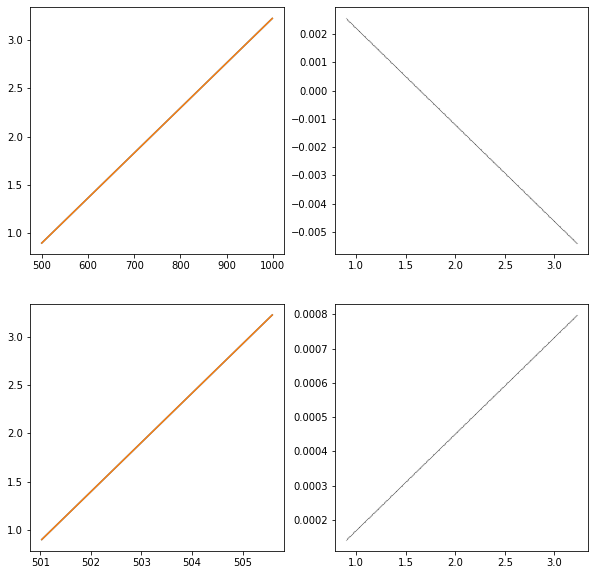

In [27]:
fig, axs = plt.subplots(2,2, figsize=(10,10))

axs[0,0].plot(x, grizli_lam)
axs[0,0].plot(grizli_x, grizli_lam)

axs[0,1].plot(grizli_lam, x-grizli_x, 'o', color='black', markersize=0.1)

axs[1,0].plot(y, grizli_lam)
axs[1,0].plot(grizli_y+500, grizli_lam)

axs[1,1].plot(grizli_lam, y-(grizli_y+500),'o', color='black', markersize=0.1)

Comparison to GRISMCONF

In [28]:
import grismconf

In [29]:
C = grismconf.Config('/Users/rosteen/projects/astrogrism_sandbox/CONFFILES/G141.conf')
x0 = 500
y0 = 500
dt = np.abs(1/(C.DISPX('+1',x0,y0,1)-C.DISPX('+1',x0,y0,0)))
t = np.arange(0.,1.,dt)
dxs = C.DISPX('+1',x0,y0,t)
dys = C.DISPY('+1',x0,y0,t)
wavs = C.DISPL('+1',x0,y0,t)/1e4

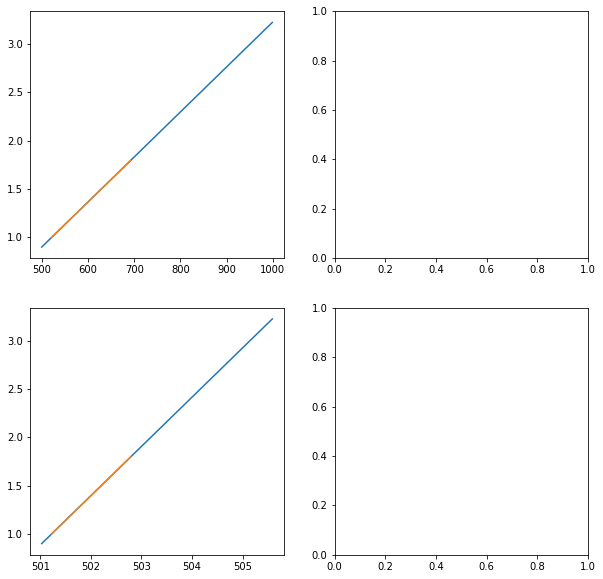

In [30]:
fig, axs = plt.subplots(2,2, figsize=(10,10))

axs[0,0].plot(x, grizli_lam)
axs[0,0].plot(x0+dxs, wavs)

#axs[0,1].plot(grizli_lam, x-grizli_x, 'o', color='black', markersize=0.1)

axs[1,0].plot(y, grizli_lam)
axs[1,0].plot(y0+dys, wavs)

#axs[1,1].plot(grizli_lam, y-(grizli_y+500),'o', color='black', markersize=0.1)

Comparison with astropy.wcs

In [31]:
detector2world = wcsobj.get_transform('detector','world')

In [32]:
from astropy.wcs import WCS as aWCS
grism_wcs = aWCS(grism_image_hdulist['SCI'].header)

In [33]:
#compare the coordinates at the reference point

In [34]:
for keyword in ['CRPIX1','CRPIX2','CRVAL1','CRVAL2']:
    print(keyword, grism_image_hdulist['SCI'].header[keyword])

CRPIX1 507.0
CRPIX2 507.0
CRVAL1 53.0734956586377
CRVAL2 -27.70721823660666


In [35]:
# detector2world transformation vs. header info
ra_ref, dec_ref = detector2world(507,507,1,2)[:2]
np.array([ra_ref, dec_ref])- np.array([grism_image_hdulist['SCI'].header['CRVAL1'],grism_image_hdulist['SCI'].header['CRVAL2']])

array([ 0.0596371 , -0.00288676])

In [36]:
0.0596371*3600/0.1, 0.00288676*3600/0.1

(2146.9356, 103.92336)

In [37]:
#astropy SIP coeff transformation vs. header info
astropy_ra, astropy_dec = grism_wcs.pixel_to_world(507,507).ra.value, grism_wcs.pixel_to_world(507,507).dec.value
np.array([astropy_ra, astropy_dec])- np.array([grism_image_hdulist['SCI'].header['CRVAL1'],grism_image_hdulist['SCI'].header['CRVAL2']])

array([ 5.14724627e-05, -2.18301100e-05])

In [38]:
xx = np.arange(0,1014, 20)
yy = np.arange(0,1014, 20)

ra, dec = detector2world(xx,yy,0,0)[:2]
astropy_coords = grism_wcs.pixel_to_world(xx, yy)
print(astropy_coords.ra.value)

[53.04780948 53.04881101 53.04981368 53.05081749 53.05182245 53.05282855
 53.05383578 53.05484414 53.05585364 53.05686427 53.05787603 53.05888891
 53.05990292 53.06091806 53.06193431 53.06295169 53.06397019 53.0649898
 53.06601054 53.06703239 53.06805535 53.06907943 53.07010462 53.07113093
 53.07215835 53.07318688 53.07421653 53.07524728 53.07627915 53.07731213
 53.07834622 53.07938142 53.08041773 53.08145516 53.0824937  53.08353335
 53.08457411 53.08561599 53.08665898 53.08770309 53.08874832 53.08979467
 53.09084213 53.09189071 53.09294042 53.09399124 53.0950432  53.09609628
 53.09715048 53.09820582 53.09926228]


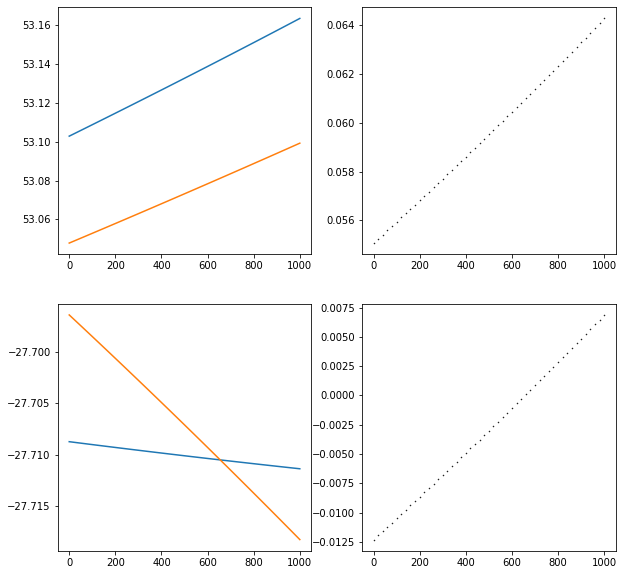

In [39]:
fig, axs = plt.subplots(2,2, figsize=(10,10))

axs[0,0].plot(xx, ra)
axs[0,0].plot(xx, astropy_coords.ra.value)

axs[0,1].plot(xx, ra-astropy_coords.ra.value, 'o', color='black', markersize=0.5)

axs[1,0].plot(yy, dec)
axs[1,0].plot(yy, astropy_coords.dec.value)

axs[1,1].plot(yy, dec-astropy_coords.dec.value,  'o', color='black', markersize=0.5)


### Investigation by Ricky below

In [40]:
ra_ref, dec_ref = detector2world(507,507,1,2)[:2]
print(ra_ref, dec_ref)
#CRVAL1 53.0734956586377
#CRVAL2 -27.70721823660666

53.13313275786976 -27.710104997069145


In [41]:
detector2world.parameters

array([ 1.00000000e+00,  1.00000000e+00,  5.07000000e+02,  5.07000000e+02,
        0.00000000e+00,  7.62272452e-04,  2.73701239e-08,  7.42658973e-12,
       -2.88787413e-14,  1.35442033e-01, -2.20363887e-08, -1.84917602e-11,
       -5.15716891e-14,  3.31474484e-06,  1.32359991e-11,  7.38529043e-14,
        8.18417469e-12,  1.09799094e-14,  9.23652160e-14,  0.00000000e+00,
        1.20985366e-01,  3.63461504e-06, -2.83741485e-11,  1.05099469e-13,
       -4.07565036e-04,  8.43227042e-07,  7.78718062e-12, -7.57256400e-14,
       -4.18426183e-08, -2.78438071e-11,  4.26096909e-14,  6.25530443e-13,
        2.19498627e-14,  1.22467742e-14,  1.01900005e+00, -5.07000029e-01,
        2.77777778e-04,  2.77777778e-04,  2.83055570e-04,  1.40833341e-04,
        4.50000000e+01, -2.77072182e+01, -5.30734957e+01])

In [42]:
detector2world.inputs_map()

{'x00': (<Shift(offset=1.)>, 'x'),
 'x10': (<Shift(offset=1.)>, 'x'),
 'x01': (<Identity(2)>, 'x0'),
 'x11': (<Identity(2)>, 'x1')}

In [43]:
0.0596371/3.61482227373837E-05

1649.7934195344164

In [44]:
0.0596371/1.04266330591494E-05

5719.689151971093

In [45]:
0.00288676/-3.2255821017724E-05

-89.49578429312886

In [46]:
-3.2255821017724E-05+(1.04266330591494E-05 * 0.5)

-2.7042504488149304e-05

In [47]:
'''
reference_files['filteroffset'] = None
image_pipeline = nircam.imaging(input_model, reference_files)
imagepipe = []
world = image_pipeline.pop()
for cframe, trans in image_pipeline:
    trans = trans & (Identity(2))
    imagepipe.append((cframe, trans))
imagepipe.append((world))
grism_pipeline.extend(imagepipe)
'''
print(image_pipeline)
print(world)

[(<Frame2D(name="detector", unit=(Unit("pix"), Unit("pix")), axes_names=('x', 'y'), axes_order=(0, 1))>, <CompoundModel(offset_0=1., offset_1=1., offset_2=507., offset_3=507., c0_0_5=0., c1_0_5=0.00076227, c2_0_5=0.00000003, c3_0_5=0., c4_0_5=-0., c0_1_5=0.13544203, c0_2_5=-0.00000002, c0_3_5=-0., c0_4_5=-0., c1_1_5=0.00000331, c1_2_5=0., c1_3_5=0., c2_1_5=0., c2_2_5=0., c3_1_5=0., c0_0_6=0., c1_0_6=0.12098537, c2_0_6=0.00000363, c3_0_6=-0., c4_0_6=0., c0_1_6=-0.00040757, c0_2_6=0.00000084, c0_3_6=0., c0_4_6=-0., c1_1_6=-0.00000004, c1_2_6=-0., c1_3_6=0., c2_1_6=0., c2_2_6=0., c3_1_6=0., offset_7=1.01900005, offset_8=-0.50700003)>), (<Frame2D(name="v2v3", unit=(Unit("arcsec"), Unit("arcsec")), axes_names=('x', 'y'), axes_order=(0, 1))>, <CompoundModel(factor_0=0.00027778, factor_1=0.00027778, angles_3=[  0.00028306,   0.00014083,  45.        , -27.70721824, -53.07349566], name='v23tosky')>)]
(<CelestialFrame(name="world", unit=(Unit("deg"), Unit("deg")), axes_names=('lon', 'lat'), axes

In [48]:
print(image_pipeline[0][1])

Model: CompoundModel
Inputs: ('x0', 'x1')
Outputs: ('y0', 'y1')
Model set size: 1
Expression: [0] & [1] | [2] & [3] | [4] | [5] & [6] | [7] & [8]
Components: 
    [0]: <Shift(offset=1.)>

    [1]: <Shift(offset=1.)>

    [2]: <Shift(offset=507.)>

    [3]: <Shift(offset=507.)>

    [4]: <Mapping((0, 1, 0, 1))>

    [5]: <Polynomial2D(4, c0_0=0., c1_0=0.00076227, c2_0=0.00000003, c3_0=0., c4_0=-0., c0_1=0.13544203, c0_2=-0.00000002, c0_3=-0., c0_4=-0., c1_1=0.00000331, c1_2=0., c1_3=0., c2_1=0., c2_2=0., c3_1=0.)>

    [6]: <Polynomial2D(4, c0_0=0., c1_0=0.12098537, c2_0=0.00000363, c3_0=-0., c4_0=0., c0_1=-0.00040757, c0_2=0.00000084, c0_3=0., c0_4=-0., c1_1=-0.00000004, c1_2=-0., c1_3=0., c2_1=0., c2_2=0., c3_1=0.)>

    [7]: <Shift(offset=1.01900005)>

    [8]: <Shift(offset=-0.50700003)>
Parameters:
    offset_0 offset_1 offset_2 ...      offset_7            offset_8     
    -------- -------- -------- ... ------------------ -------------------
         1.0      1.0    507.0 ... 1.0

In [49]:
print(world[1])

None


In [50]:
keys = ["IDCV2REF", 'IDCV3REF', 'IDCTHETA', 'CRVAL1', 'CRVAL2']
for key in keys:
    print(grism_image_hdulist['SCI'].header[key])

1.019000053405762
-0.5070000290870667
45.0
53.0734956586377
-27.70721823660666


In [51]:
ra_diffs = ra-astropy_coords.ra.value
print(ra_diffs[1]-ra_diffs[0])
print(ra_diffs[2]-ra_diffs[1])
print(ra_diffs[-2]-ra_diffs[-3])
print(ra_diffs[-1]-ra_diffs[-2])

0.00017391029761881782
0.00017419178918487432
0.00019640384749664008
0.00019709896874786637


In [52]:
0.00017419178918487432-0.00017391029761881782

2.8149156605650205e-07

In [53]:
0.00019709896874786637-0.00019640384749664008

6.951212512262828e-07

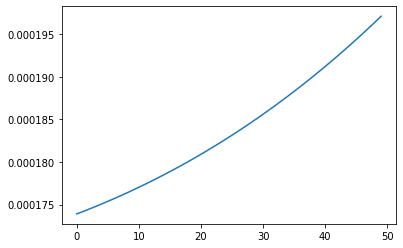

In [54]:
plt.plot(ra_diffs[1:]-ra_diffs[:-1])

I don't think the fact that the difference is changing by increasing amount is the first things to worry about, but it might be a clue. 

In [55]:
g2w = wcsobj.get_transform("grism_detector", "world")
g2w

<CompoundModel(offset_1=1., offset_2=1., offset_3=507., offset_4=507., c0_0_6=0., c1_0_6=0.00076227, c2_0_6=0.00000003, c3_0_6=0., c4_0_6=-0., c0_1_6=0.13544203, c0_2_6=-0.00000002, c0_3_6=-0., c0_4_6=-0., c1_1_6=0.00000331, c1_2_6=0., c1_3_6=0., c2_1_6=0., c2_2_6=0., c3_1_6=0., c0_0_7=0., c1_0_7=0.12098537, c2_0_7=0.00000363, c3_0_7=-0., c4_0_7=0., c0_1_7=-0.00040757, c0_2_7=0.00000084, c0_3_7=0., c0_4_7=-0., c1_1_7=-0.00000004, c1_2_7=-0., c1_3_7=0., c2_1_7=0., c2_2_7=0., c3_1_7=0., offset_8=1.01900005, offset_9=-0.50700003, factor_11=0.00027778, factor_12=0.00027778, angles_14=[  0.00028306,   0.00014083,  45.        , -27.70721824, -53.07349566])>

In [56]:
g2w.inputs

('x', 'y', 'x0', 'y0', 'order')

In [57]:
g2w(507, 507, 507, 507, 0)

2021-05-11 15:08:09,377 - stpipe - WARNING - /Users/rosteen/projects/astrogrism_sandbox/HST/dispersion_models.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coeffs = np.array([1, x, y, x**2, x*y, y**2])

2021-05-11 15:08:09,379 - stpipe - WARNING - /Users/rosteen/opt/anaconda3/envs/astrogrism/lib/python3.9/site-packages/astropy/modeling/math_functions.py:63: AstropyUserWarning: Models in math_functions are experimental.
  warnings.warn("Models in math_functions are experimental.", AstropyUserWarning)



(53.13313275786976, -27.710104997069145, 58.02213869105162, 0.0)

In [58]:
d2g = wcsobj.get_transform("detector", "grism_detector")
d2g.inputs

('x', 'y', 'wavelength', 'order')

In [59]:
d2g(507, 507, 1.4, 1)

(614.2708190456062, 508.99982484389625, 507.0, 507.0, 1.0)

In [60]:
g2w(614.2708190456062, 508.99982484389625, 507.0, 507.0, 1.0)

(53.13313275786976, -27.710104997069145, 1.4046622732230691, 1.0)

In [61]:
for key in grism_image_hdulist['SCI'].header:
    print(key, grism_image_hdulist['SCI'].header[key])

XTENSION IMAGE
BITPIX -32
NAXIS 2
NAXIS1 1014
NAXIS2 1014
PCOUNT 0
GCOUNT 1
ORIGIN HSTIO/CFITSIO March 2010
DATE 2016-09-14
INHERIT True
EXTNAME SCI
EXTVER 1
ROOTNAME ib6o23rsq
EXPNAME ib6o23rsq
BUNIT ELECTRONS/S
 
      / World Coordinate System and Related Parameters


      / REPEATED EXPOSURES INFORMATION


      / READOUT DEFINITION PARAMETERS


      / READOUT PARAMETERS


      / DATA PACKET INFORMATION


      / IMAGE STATISTICS AND DATA QUALITY FLAGS

 
      / World Coordinate System and Related Parameters


      / REPEATED EXPOSURES INFORMATION


      / READOUT DEFINITION PARAMETERS


      / READOUT PARAMETERS


      / DATA PACKET INFORMATION


      / IMAGE STATISTICS AND DATA QUALITY FLAGS

 
      / World Coordinate System and Related Parameters


      / REPEATED EXPOSURES INFORMATION


      / READOUT DEFINITION PARAMETERS


      / READOUT PARAMETERS


      / DATA PACKET INFORMATION


      / IMAGE STATISTICS AND DATA QUALITY FLAGS

WCSAXES 2
CRPIX1 507.0
CRPIX2 5

In [62]:
# Checking for this SIP distortion stuff

grism_wcs.sip

In [63]:
# This doesn't return exactly the reference values, so I'm guessing it's using the SIP distortion coeffs
grism_wcs.pixel_to_world(507, 507)

<SkyCoord (ICRS): (ra, dec) in deg
    (53.07354713, -27.70724007)>

In [64]:
grism_wcs.pixel_to_world(509, 509)

<SkyCoord (ICRS): (ra, dec) in deg
    (53.07365008, -27.70728373)>

In [65]:
grism_wcs.has_distortion

True

In [66]:
print(53.13313275786976 - 53.07365008)
print(-27.710104997069145 - -27.70728373)

0.05948267786975947
-0.0028212670691445396
